## Part II: ML analysis

In [114]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
# Load the dataset
df = pd.read_csv('./data/df.csv')
df.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,...,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Returned
0,CA-2014-AB10015140-41954,2014-11-11,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,...,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,No
1,IN-2014-JR162107-41675,2014-02-05,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,...,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,No
2,IN-2014-CR127307-41929,2014-10-17,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,...,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,No
3,ES-2014-KM1637548-41667,2014-01-28,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,...,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,No
4,SG-2014-RH9495111-41948,2014-11-05,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,...,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,No


In [125]:
df['Returned'] = df['Returned'].apply(lambda x: 1 if x=="Yes" else 0).astype('float') # 1 = returned

### Question 2

We see if the processing time predicts whether the item will be returned.

For this we use a logistic regression. 

In [126]:
# Calculate processing time

df['Ship.Date'] = pd.to_datetime(df['Ship.Date'])
df['Order.Date'] = pd.to_datetime(df['Order.Date'])
df['ProcessingTime'] = (df['Ship.Date'] - df['Order.Date'])/np.timedelta64(1, 'D')

In [127]:
# Run Logistic regression
x = np.array(df['ProcessingTime'])
x = sm.add_constant(x)
y = np.array(df['Returned'])

logit = sm.Logit(y,x)
result = logit.fit()
result.summary()



Optimization terminated successfully.
         Current function value: 0.178219
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                51290
Model:                          Logit   Df Residuals:                    51288
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:               0.0001266
Time:                        16:11:52   Log-Likelihood:                -9140.9
converged:                       True   LL-Null:                       -9142.0
                                        LLR p-value:                    0.1281
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1724      0.055    -57.433      0.000      -3.281      -3.064
x1             0.0192      0.013      1.518      0.129      -0.006       0.044
==============================================================================
"""

The regression coefficient is not statistically significant (p-value is 0.13). Therefore we cannot make a conclusion of whether the processing time affects the odds of returns.

### Question 3

In [128]:
returned_prod = df.groupby('Product.ID').agg({"Returned":"sum"}).reset_index() #Calculate how many times a product was returned
returned_prod.columns = ["Product.ID", "ProdRet"]
df = pd.merge(df, returned_prod, on='Product.ID', how="left") # Merge with the dataset
df.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,...,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Returned,ProcessingTime,ProdRet
0,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,...,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,0.0,2.0,0.0
1,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,...,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,0.0,2.0,2.0
2,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,...,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,0.0,1.0,2.0
3,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,...,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,0.0,2.0,0.0
4,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,...,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,0.0,1.0,0.0


We perform cross validated logistic regression selection.

In [107]:
df.columns

Index(['Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode', 'Customer.ID',
       'Customer.Name', 'Segment', 'Postal.Code', 'City', 'State', 'Country',
       'Region', 'Market', 'Product.ID', 'Category', 'Sub.Category',
       'Product.Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping.Cost', 'Order.Priority', 'Returned', 'ProdRet'],
      dtype='object')

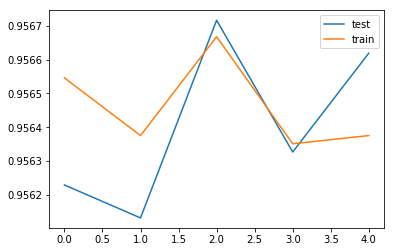

In [140]:


# Select features and response
tmp_ = df.copy()

category = tmp_.loc[:,['Ship.Mode',  'Segment',
       'Region', 'Market', 'Category', 'Sub.Category', 'Order.Priority']] 
numeric =  tmp_.loc[:,['Returned','ProcessingTime', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping.Cost',  'ProdRet']]

category = pd.get_dummies(category)

tmp_ = numeric.join(category)


X = tmp_.drop("Returned", axis=1)
y = tmp_.loc[:,'Returned']



skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

intercepts = []
coefs = []
train_scores = []
test_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(C=1e8)
    result = model.fit(X_train, y_train)
    coef = result.coef_
    intercept = result.intercept_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    intercepts = intercepts + [intercept]
    coefs = coefs + [coef]
    train_scores = train_scores + [train_score]
    test_scores = test_scores + [test_score]

plot = pd.DataFrame({'test':test_scores, 'train':train_scores})
plot.plot()

    
    
    

Find the best fit model

In [158]:
pd.DataFrame(coefs[2].T).set_index(X.columns)


,0
ProcessingTime,-0.025611
Sales,-0.000261
Quantity,0.002137
Discount,0.179621
Profit,0.000100
Shipping.Cost,0.001781
ProdRet,0.396759
Ship.Mode_First Class,-0.401350
Ship.Mode_Same Day,-0.444363
Ship.Mode_Second Class,-0.423744


Best fit score

In [160]:
print('test score {}'.format(test_scores[2]))
print('train score {}'.format(train_scores[2]))

test score 0.956716708910119
train score 0.9566679664651979
